In [1]:
import requests
import pandas as pd

from datetime import datetime as dt
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# authorization:ambrosiaに登録し、認証情報を取得したものを渡す
headers = {'authorization': 'hogehoge',
           'cache-control': 'no-cache'}

begin_tstr = '2022-1-2 8:00:00'
end_tstr = '2022-1-9 8:00:00'


begin_data = dt.strptime(begin_tstr, '%Y-%m-%d %H:%M:%S')
end_data = dt.strptime(end_tstr, '%Y-%m-%d %H:%M:%S')
begin_ut = int(begin_data.timestamp())
end_ut = int(end_data.timestamp())

glucose = requests.get("https://developer.ambrosiasys.com/app/readings?begin_date={}&end_date={}".format(begin_ut, end_ut),
            headers=headers)

get_data = json.loads(glucose.text.replace("'", '"'))
for i in range(len(get_data['readings'])):
    get_data['readings'][i]['reading_time'] = dt.fromtimestamp((int(get_data['readings'][i]['reading_time']) / 1000))

START_TIME = get_data['readings'][0]['reading_time']
END_TIME = get_data['readings'][-1]['reading_time']
print(START_TIME)
print(END_TIME)

glu_data = [i['reading'] for i in get_data['readings']]
date = [i['reading_time'] for i in get_data['readings']]
glu_df = pd.DataFrame(glu_data, index=date).rename(columns={0: 'glucose'})
glu_df

2022-01-02 09:09:21
2022-01-09 07:58:51


,glucose
2022-01-02 09:09:21,152
2022-01-02 09:09:23,152
2022-01-02 09:14:21,153
2022-01-02 09:14:22,153
2022-01-02 09:19:20,161
...,...
2022-01-09 07:38:54,101
2022-01-09 07:43:53,100
2022-01-09 07:48:53,100
2022-01-09 07:53:52,100


In [2]:
import collections
import xml.etree.ElementTree as ET
import pytz
import datetime

Step = collections.namedtuple('Step', ['creation_date', 'start_date', 'end_date', 'value'])

tree = ET.parse('export.xml')
root = tree.getroot()

step_list = []

es = root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']")
for e in es:
    creation_date_str = e.get('creationDate')
    creation_date = dt.strptime(creation_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    start_date_str = e.get('startDate')
    start_date = dt.strptime(start_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    end_date_str = e.get('endDate')
    end_date = dt.strptime(end_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    value = e.get('value')
    step = Step(creation_date, start_date, end_date, value)
    
    step_list.append(step)
print(len(step_list))

jp = pytz.timezone('Asia/Tokyo')
walk_data = []

last_date = dt.strptime('2022-1-13 00:00:00', '%Y-%m-%d %H:%M:%S')
for record in step_list:
    if begin_data.replace(tzinfo=jp) <= record.start_date.replace(tzinfo=jp) < last_date.replace(tzinfo=jp):
        walk_data.append(record)
    else:
        pass

26636


In [3]:
print(len(walk_data))
print(walk_data[0])
print(walk_data[-1])
walk_date = [i.start_date for i in walk_data]
walk = [i.value for i in walk_data]
print(len(walk_date), len(walk))

950
Step(creation_date=datetime.datetime(2022, 1, 2, 8, 23, 59, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), start_date=datetime.datetime(2022, 1, 2, 8, 12, 2, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), end_date=datetime.datetime(2022, 1, 2, 8, 21, 56, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), value='325')
Step(creation_date=datetime.datetime(2022, 1, 12, 23, 26, 7, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), start_date=datetime.datetime(2022, 1, 12, 23, 11, 30, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), end_date=datetime.datetime(2022, 1, 12, 23, 11, 33, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400))), value='3')
950 950


In [64]:
walk_date[0]

datetime.datetime(2022, 1, 2, 8, 12, 2, tzinfo=datetime.timezone(datetime.timedelta(seconds=32400)))

In [4]:
walk_df = pd.DataFrame(walk, index=walk_date).rename(columns={0: "walk"})
walk_df

,walk
2022-01-02 08:12:02+09:00,325
2022-01-02 08:22:29+09:00,74
2022-01-02 08:34:18+09:00,266
2022-01-02 08:44:18+09:00,1108
2022-01-02 08:54:19+09:00,1110
...,...
2022-01-12 22:44:56+09:00,28
2022-01-12 22:45:58+09:00,2
2022-01-12 22:46:24+09:00,5
2022-01-12 23:07:39+09:00,2


In [51]:
result = pd.read_csv('result.csv', encoding='shift_jis', index_col="Unnamed: 0").dropna(how='any')
result

,Enagy(kcal),Protein(g),Fat(g),Carbo(g),Ca(mg),Mg(mg),Fe(mg),Zn(mg),VitA(ﾎｼg),VitD(ﾎｼg),VitB1(mg),VitB2(mg),VitB6(mg),Fiber(g),Saturated fat(g),VitC(mg),NoW,Salt(g),Label
つけめん,602,26.5,10.7,107.9,100.0,49.0,2.1,1.4,59.0,0.8,0.25,0.23,0.13,8.3,3.41,7.0,0.0,2.127,70.308458
納豆オムレツ,338,21.3,26.8,7.7,97.0,66.0,3.3,2.1,171.0,2.5,0.10,0.61,0.23,2.4,5.00,2.0,0.0,1.500,27.705401
あんかけチャーハン,844,30.2,36.3,107.0,69.0,64.0,2.1,3.6,234.0,3.3,0.17,0.37,0.25,2.5,5.63,6.0,0.0,3.900,89.671354
あんかけチャーハン+歩数,844,30.2,36.3,107.0,69.0,64.0,2.1,3.6,234.0,3.3,0.17,0.37,0.25,2.5,5.63,6.0,10000.0,3.900,103.019022


In [52]:
result.corr()

,Protein(g),Fat(g),Carbo(g),Ca(mg),Mg(mg),Fe(mg),Zn(mg),VitA(ﾎｼg),VitD(ﾎｼg),VitB1(mg),VitB2(mg),VitB6(mg),Fiber(g),Saturated fat(g),VitC(mg),NoW,Salt(g),Label
Protein(g),1.000000,0.450245,0.906647,-0.825284,-0.032603,-0.910208,0.704032,0.439720,0.401239,0.462844,-0.653563,0.249382,-0.070953,0.365811,0.801353,0.498636,0.949571,0.985418
Fat(g),0.450245,1.000000,0.031505,-0.875820,0.877751,-0.040019,0.951100,0.999931,0.998533,-0.583113,0.381551,0.976977,-0.922601,0.995722,-0.173323,0.484367,0.707513,0.409848
Carbo(g),0.906647,0.031505,1.000000,-0.509992,-0.451226,-0.999964,0.338695,0.019756,-0.022658,0.793616,-0.911868,-0.182460,0.356498,-0.060988,0.978916,0.329305,0.728640,0.909412
Ca(mg),-0.825284,-0.875820,-0.509992,1.000000,-0.537511,0.517301,-0.982071,-0.870087,-0.848403,0.118611,0.111956,-0.752687,0.621851,-0.827475,-0.323534,-0.575863,-0.960734,-0.791853
Mg(mg),-0.032603,0.877751,-0.451226,-0.537511,1.000000,0.443607,0.686837,0.883321,0.902405,-0.901059,0.777778,0.959760,-0.994636,0.918268,-0.624001,0.274614,0.282427,-0.069997
Fe(mg),-0.910208,-0.040019,-0.999964,0.517301,0.443607,1.000000,-0.346699,-0.028273,0.014141,-0.788405,0.908338,0.174078,-0.348526,0.052483,-0.977140,-0.333333,-0.734448,-0.912628
Zn(mg),0.704032,0.951100,0.338695,-0.982071,0.686837,-0.346699,1.000000,0.947404,0.932980,-0.303664,0.077377,0.863303,-0.758331,0.918488,0.139361,0.557733,0.891204,0.666858
VitA(ﾎｼg),0.439720,0.999931,0.019756,-0.870087,0.883321,-0.028273,0.947404,1.000000,0.999100,-0.592621,0.392388,0.979417,-0.927071,0.996739,-0.184886,0.480640,0.699158,0.399278
VitD(ﾎｼg),0.401239,0.998533,-0.022658,-0.848403,0.902405,0.014141,0.932980,0.999100,1.000000,-0.626244,0.431039,0.987095,-0.942134,0.999264,-0.226394,0.466644,0.668211,0.360682
VitB1(mg),0.462844,-0.583113,0.793616,0.118611,-0.901059,-0.788405,-0.303664,-0.592621,-0.626244,1.000000,-0.973419,-0.743009,0.851366,-0.655687,0.901162,-0.027186,0.161557,0.489682


In [36]:
food = requests.get("https://developer.ambrosiasys.com/app/notes?begin_date={}&end_date={}".format(begin_ut, end_ut),
            headers=headers)

In [37]:
food.text

'{"message":"no_data_found"}'

In [44]:
glucose_list = [int(record['reading']) for record in get_data['readings'] if record['reading'] != 'NA']
glucose_list = np.array(glucose_list)

In [46]:
index = np.arange(glucose_list.shape[0])
index

array([   0,    1,    2, ..., 1844, 1845, 1846])

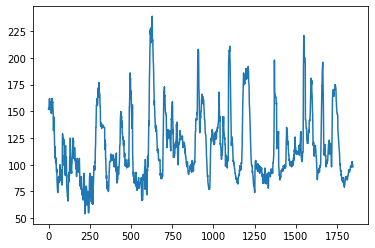

In [47]:
plt.plot(index, glucose_list)
plt.show()

In [32]:
import xml.etree.ElementTree as ET
from datetime import datetime

tree = ET.parse('export_cda.xml')
root = tree.getroot()

step_list2 = []

es = root.findall(".//Record[@type='HKQuantityTypeIdentifierStepCount']")
for e in es:
    creation_date_str = e.get('creationDate')
    creation_date = datetime.strptime(creation_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    start_date_str = e.get('startDate')
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    end_date_str = e.get('endDate')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d %H:%M:%S %z')
    
    value = e.get('value')
    step = Step(creation_date, start_date, end_date, value)
    
    step_list2.append(step)
    
print(len(step_list2))

0


In [2]:
!touch ./data/step.log

In [58]:
import os
import json
import httplib2
import requests

import time
from datetime import datetime, timedelta
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow, flow_from_clientsecrets
from oauth2client.file import Storage

OAUTH_SCOPE = 'https://www.googleapis.com/auth/fitness.activity.read'
# OAUTH_SCOPE = 'https://www.googleapis.com/auth/fitness.blood_glucose.read'
# 歩数を取得するdata source
# DATA_SOURCE = "derived:com.google.step_count.delta:com.google.android.gms:estimated_steps"
# これはよくわかりません
# DATA_SOURCE = "derived:com.google.activity.segment:com.google.android.gms:merge_activity_segments"
# 運動強度の高いレコードを取れる
DATA_SOURCE = "derived:com.google.heart_minutes:com.google.android.gms:merge_heart_minutes"
REDIRECT_URI = 'urn:ietf:wg:oauth:2.0:oob'
CREDENTIALS_FILE = "./secret/credentials"
# CREDENTIALS_FILE = "./secret/harakenta"

def auth_data():

    credentials = ""

    if os.path.exists(CREDENTIALS_FILE):
        credentials = Storage(CREDENTIALS_FILE).get()
    else:
        #flow = OAuth2WebServerFlow(CLIENT_ID, CLIENT_SECRET, OAUTH_SCOPE, REDIRECT_URI)
        flow = flow_from_clientsecrets(
            # API有効化時に取得したOAuth用のJSONファイルを指定
            './secret/oauth2.json',
            # スコープを指定
            scope=OAUTH_SCOPE,
            # ユーザーの認証後の、トークン受け取り方法を指定（後述）
            redirect_uri=REDIRECT_URI)

        authorize_url = flow.step1_get_authorize_url()
        print('下記URLをブラウザで起動してください。')
        print(authorize_url)

        code = input('Codeを入力してください: ').strip()
        credentials = flow.step2_exchange(code)

        if not os.path.exists(CREDENTIALS_FILE):
            Storage(CREDENTIALS_FILE).put(credentials)

    # Create an httplib2.Http object and authorize it with our credentials
    http = httplib2.Http()
    http = credentials.authorize(http)

    fitness_service = build('fitness', 'v1', http=http)

    return fitness_service


def retrieve_data(fitness_service, dataset):

    return fitness_service.users().dataSources(). \
        datasets(). \
        get(userId='me', dataSourceId=DATA_SOURCE, datasetId=dataset). \
        execute()


def nanoseconds(nanotime):
    """
    ナノ秒に変換する
    """
    dt = datetime.fromtimestamp(nanotime // 1000000000)
    return dt.strftime('%Y-%m-%d %H:%M:%S')


def logwrite(date, step):
    with open('./data/step.log', 'a') as outfile:
        outfile.write(str(date) + "," + str(step) + "\n")


if __name__ == "__main__":

    authdata = auth_data()

    # 前日分のデータを取得
    TODAY = datetime.today() - timedelta(days=10)
#     TODAY = datetime.today()
    STARTDAY = datetime(TODAY.year, TODAY.month, TODAY.day, 0, 0, 0)
    NEXTDAY = datetime(TODAY.year, TODAY.month, TODAY.day, 23, 59, 59)
    NOW = datetime.today()

    START = int(time.mktime(STARTDAY.timetuple())*1000000000)
    NEXT = int(time.mktime(NEXTDAY.timetuple())*1000000000)
    END = int(time.mktime(NOW.timetuple())*1000000000)
    data_set = "%s-%s" % (START, NEXT)

    while True:

        if END < NEXT:
            break

        dataset = retrieve_data(authdata, data_set)

        starts = []
        ends = []
        values = []
#         print(dataset['point'] == list())
        if dataset['point'] == list():
            print("From: {}".format(nanoseconds(int(dataset["minStartTimeNs"]))))
            print("To: {}".format(nanoseconds(int(dataset["maxEndTimeNs"]))))
            print("Steps:{}".format(0))
            startdate = STARTDAY.date()
            logwrite(startdate, step)

            STARTDAY = STARTDAY + timedelta(days=1)
            NEXTDAY = NEXTDAY + timedelta(days=1)
            START = int(time.mktime(STARTDAY.timetuple())*1000000000)
            NEXT = int(time.mktime(NEXTDAY.timetuple())*1000000000)
            data_set = "%s-%s" % (START, NEXT)

            time.sleep(5)
            continue
            
        else:
            for point in dataset["point"]:
#                 print(point)
                if int(point["startTimeNanos"]) > START:
                    starts.append(int(point["startTimeNanos"]))
                    ends.append(int(point["endTimeNanos"]))
                    # 歩数の時これ
    #                 values.append(point['value'][0]['intVal'])
                    values.append(point['value'][0]['fpVal'])
                    print('start:{}'.format(nanoseconds(int(point["startTimeNanos"]))))
                    print('end:{}'.format(nanoseconds(int(point["endTimeNanos"]))))
                    print('value:{}'.format(point['value'][0]['fpVal']))

            print("From: {}".format(nanoseconds(min(starts))))
            print("To: {}".format(nanoseconds(max(ends))))
            print("total:{}".format(sum(values)))
            print('*'*100)

        step = sum(values)

        startdate = STARTDAY.date()
        logwrite(startdate, step)

        STARTDAY = STARTDAY + timedelta(days=1)
        NEXTDAY = NEXTDAY + timedelta(days=1)
        START = int(time.mktime(STARTDAY.timetuple())*1000000000)
        NEXT = int(time.mktime(NEXTDAY.timetuple())*1000000000)
        data_set = "%s-%s" % (START, NEXT)

        time.sleep(5)

下記URLをブラウザで起動してください。
https://accounts.google.com/o/oauth2/auth?client_id=541001441634-e0un1dpm8s5cnj2i10f5rnf9vdj1f2lv.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Ffitness.activity.read&access_type=offline&response_type=code


KeyboardInterrupt: 